In [149]:
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import time
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [123]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [124]:
X_train = pd.DataFrame(X_train.reshape(60000, 28*28))
X_test = pd.DataFrame(X_test.reshape(10000, 28*28))

In [125]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,119,114,130,76,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,22,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,33,96,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,0,0,0,0,0,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,0
59998,0,0,0,0,0,0,0,0,0,0,...,66,54,50,5,0,1,0,0,0,0


In [126]:
z = X_train.values #returns a numpy array
min_max_scaler = MinMaxScaler()
z_scaled = min_max_scaler.fit_transform(z) #fitting and transforming
X_train = pd.DataFrame(z_scaled)

z = X_test.values #returns a numpy array
z_scaled = min_max_scaler.transform(z) #transforming without fitting
X_test = pd.DataFrame(z_scaled)

In [144]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.004348,0.0,0.0,0.000000,0.000000,...,0.466667,0.447059,0.509804,0.298039,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.086275,...,0.000000,0.000000,0.003922,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.129921,0.376471,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
59996,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
59997,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.019608,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
59998,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.258824,0.211765,0.196078,0.019608,0.0,0.003922,0.0,0.0,0.0,0.0


In [145]:
print(X_train.isna().sum().sum()
      + X_test.isna().sum().sum()
      + pd.DataFrame(y_train).isna().sum().sum()
      + pd.DataFrame(y_test).isna().sum().sum())

0


In [151]:
pca = PCA(n_components=0.9)
X_train_Reduced = pca.fit_transform(X_train)
X_test_Reduced = pca.transform(X_test)

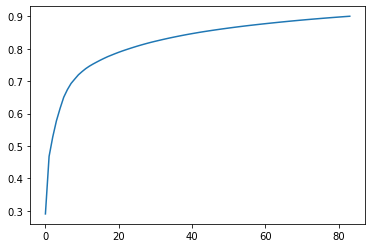

In [152]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum)

In [154]:
X_train_Reduced.shape

(60000, 84)

In [157]:
start_timeRandForests = time.time()
modelRandForests = RandomForestClassifier(n_estimators = 500, n_jobs = -1, random_state = 0)
modelRandForests.fit(X_train_Reduced, y_train)
predictionsRandForests = modelRandForests.predict(X_test_Reduced)
accuracyRandForests = metrics.accuracy_score(y_test, predictionsRandForests)
print("Accuracy (Random Forests): ", accuracyRandForests)
timeRandForests = time.time() - start_timeRandForests
print("Time taken to achive result: %s seconds" % (timeRandForests))

Accuracy (Random Forests):  0.8644
Time taken to achive result: 42.34031367301941 seconds


In [158]:
start_timeAdaBoost = time.time()
modelDecTree = DecisionTreeClassifier(random_state=0, max_depth=2)
modelAdaBoost = AdaBoostClassifier(modelDecTree, n_estimators = 1000, random_state = 0, learning_rate = 1)
modelAdaBoost.fit(X_train_Reduced, y_train)
predictionsAdaBoost = modelAdaBoost.predict(X_test_Reduced)
accuracyAdaBoost = metrics.accuracy_score(y_test, predictionsAdaBoost)
print("Accuracy (AdaBoost): ", accuracyAdaBoost)
timeAdaBoost = time.time() - start_timeAdaBoost
print("Time taken to achive result: %s seconds" % (timeAdaBoost))

Accuracy (AdaBoost):  0.6289
Time taken to achive result: 1083.1359899044037 seconds


In [155]:
start_timeXGBoost = time.time()
modelXGBoost = XGBClassifier(learning_rate = 0.2, n_estimators = 200, verbosity = 0, use_label_encoder = False,
                             n_jobs = -1, objective = 'multi:softmax', max_depth = 10)
modelXGBoost.fit(X_train_Reduced, y_train)
predictionsXGBoost = modelXGBoost.predict(X_test_Reduced)
accuracyXGBoost = metrics.accuracy_score(y_test, predictionsXGBoost)
print("Accuracy (XGBoost): ", accuracyXGBoost)
timeXGBoost = time.time() - start_timeXGBoost
print("Time taken to achive result: %s seconds" % (timeXGBoost))

Accuracy (XGBoost):  0.8843
Time taken to achive result: 357.95077538490295 seconds
